# First Notebook

# Structure 
## Part I:

Produces a series of plots based only on the files in "data/0/results/" and "data/bsrn/results" (no need for the full database). These correspond to figures 5, 8 and 9 of the publication.

## Part II:

Computes the ensemble scores, that are then scored in the 'data' folder. These ar used in the second notebook

In [ ]:

import xarray as xr
import numpy as np
#import code.features
import sites
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.basemap import Basemap
from skimage.filters import threshold_otsu
from scipy.stats import gaussian_kde
import pandas as pd
import os
import scipy

#%matplotlib inline
#to open the figures in an interactive window and to save them
%matplotlib qt 

# Part I

# Figure 5

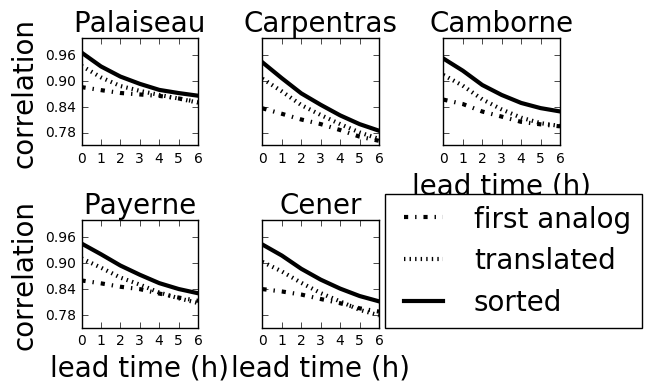

In [2]:
fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.reshape((6,))
lead = np.arange(1, 7)

ax[5].axis('off')
sites = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

for site in xrange(5):
    stats = xr.open_dataset('data/0/results/' + str(site) + '_stat.nc')
    
    
    ax[site].plot(stats.best_correlation_before.groupby('lead').mean().values[:7], 
             'k-.' ,label='first analog', linewidth=3.0)
    ax[site].plot(stats.first_correlation_after.groupby('lead').mean().values[:7], 
             'k:',label='translated', linewidth=3.0)
    ax[site].plot(stats.best_correlation_after.groupby('lead').mean().values[:7], 
             'k-', label='sorted', linewidth=3.0)
    
    ax[site].set_title(sites[site], fontsize=20)
    ax[site].set_ylim([0.75, 1])
    yloc = plt.MaxNLocator(5)
    if site != 0 and site !=3:
        ax[site].yaxis.set_major_formatter(plt.NullFormatter())
    ax[site].yaxis.set_major_locator(yloc)
    if site in [0,3]:
        ax[site].set_ylabel('correlation', fontsize=20)
    if site in [2,3,4]:
        ax[site].set_xlabel('lead time (h)', fontsize= 20)

ax[4].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,
            fontsize=20)
fig.tight_layout()


# Figure 9

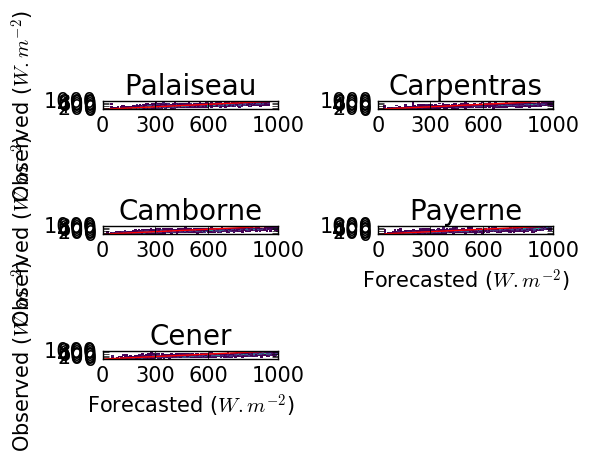

In [9]:
# scatter plot
fig, axes = plt.subplots(nrows=3, ncols=2)
ax = axes.reshape((6,))
lead = np.arange(1, 7)
size=80
ax[5].axis('off')
sites = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

for site in xrange(5):
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                              '_truth.nc').sel(time=point.time.values)
    
    trans = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
    forecasted = trans.dropna('time')
    
    truth = ssi.truth.sel(lead=slice(1,6))*(forecasted/forecasted)
    
    xlen = forecasted.values.shape[0]
    H, xedges, yedges = np.histogram2d(forecasted.values.reshape((xlen*6,)), truth.values.reshape((xlen*6,)), bins=100)

    Hmasked = np.ma.masked_where(H==0, H)
    im = ax[site].pcolormesh(xedges, yedges, Hmasked, cmap='viridis')
    ax[site].plot([0,1000], [0,1000], 'r-')
    
    ax[site].set_title(sites[site], fontsize=20)


    yloc = plt.MaxNLocator(5)
    ax[site].yaxis.set_major_locator(yloc)
    ax[site].set_xlim([0,1000])
    ax[site].set_xticks([0,300,600, 1000])
    if site in [0,2,4]:
        ax[site].set_ylabel('Observed ($W.m^{-2}$)', fontsize=15)
    if site in [3,4]:
        ax[site].set_xlabel('Forecasted ($W.m^{-2}$)', fontsize= 15)

ax[4].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,
            fontsize=20)
fig.tight_layout()
#fig.colorbar(im, ax=ax[4])

### Fit the linear regression to correct the bias

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
size = 80

coef = np.zeros((5,6))
intercept = np.zeros((5,6))
scores = np.zeros((5,6))

for site in xrange(5):
    #load data and compute mae
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                              '_truth.nc').sel(time=point.time.values)

    trans = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
    bias = (trans - ssi.truth.sel(lead=slice(1,6))).dropna('time')
    forecasted = trans*(bias/bias)
    
    for lead in xrange(6):
        y = bias.isel(lead=lead).values[:,None]
        X = forecasted.isel(lead=lead).values[:,None]
        regression = LinearRegression()
        regression.fit(X, y)
        coef[site, lead] = regression.coef_
        intercept[site, lead] = regression.intercept_
        scores[site, lead] = regression.score(X,y)
    
coefs = xr.Dataset({'coef': (['site', 'lead'], coef),
                    'intercept': (['site', 'lead'], intercept)},
                   coords={'site': np.arange(5),
                          'lead': np.arange(1,7)})

Linear regression scores

In [13]:
scores

array([[  1.32442216e-04,   1.03364647e-03,   7.52340451e-03,
          9.23753732e-03,   6.03944512e-03,   4.15921607e-03],
       [  1.35524098e-02,   7.32555946e-03,   4.46314887e-06,
          4.03689029e-03,   1.52430825e-02,   3.13372884e-02],
       [  1.63867035e-02,   4.51750560e-03,   6.32014620e-04,
          1.00056976e-03,   4.37416182e-03,   1.14296365e-02],
       [  3.88604830e-04,   2.20964476e-05,   2.60077260e-03,
          7.87119054e-03,   1.79708982e-02,   3.40751135e-02],
       [  9.34992307e-06,   1.27403728e-04,   5.85870890e-05,
          1.26234566e-03,   1.34653078e-02,   4.43144237e-02]])

# Figure 8 

site n° 0
analog [ 0.03960983 & 0.06935477 & 0.08638986 & 0.08792037 & 0.08288789 &
  0.06229484]
persistance [ 0.00191001 & 0.00317325 & 0.00747389 & 0.00650392 & 0.00815214 &
  0.00910614]
climato [ 0.03885899 & 0.04404672 & 0.05017009 & 0.05052375 & 0.05356963 &
  0.05364038]
ar1 [-0.00138301 & 0.00037182 & 0.00184365 & 0.00041205 & 0.00441812 &
  0.00788078]
site n° 1
analog [ 0.02029981 & 0.03032137 & 0.03830155 & 0.04123997 & 0.03347248 &
  0.01081368]
persistance [ 0.00116499 &-0.00071049 & 0.00089927 &-0.00051287 &-0.00173598 &
 -0.00278871]
climato [ 0.01884816 & 0.01893979 & 0.02211428 & 0.02437879 & 0.0242693  &
  0.01986442]
ar1 [ 0.00477189 & 0.00124666 &-0.00070828 &-0.0032523  &-0.00473029 &
 -0.00886085]
site n° 2
analog [ 0.12359499 & 0.15671671 & 0.16440542 & 0.15963418 & 0.13733461 &
  0.09901659]
persistance [-0.01106158 &-0.02881568 &-0.04736455 &-0.06854995 &-0.08648076 &
 -0.10211362]
climato [ 0.02617706 & 0.02236951 & 0.01796459 & 0.01505239 & 0.01392192 &
  0.

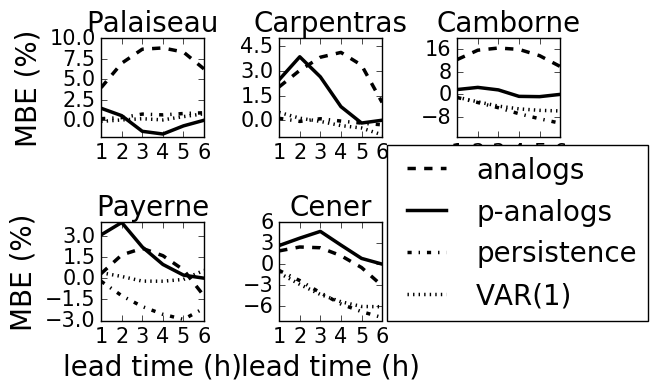

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.reshape((6,))
lead = np.arange(1, 7)
ax[5].axis('off')
sites = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# Number of analogs
size=80

# Stores the scores values
mens = 0
mloc = 0
mpers = 0
mclim = 0
mar = 0

for site in xrange(5):
    print 'site n°', site
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                              '_truth.nc').sel(time=point.time.values)

    # Analog score
    trans = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
    rmse = ((trans - ssi.truth.sel(lead=slice(1,6))
               ).groupby('lead').mean()
            )/ssi.truth.sel(lead=slice(1,6)).groupby('lead').mean()
    corrected = ((trans - trans*coefs.coef.sel(site=site) - coefs.intercept.sel(site=site)- ssi.truth.sel(lead=slice(1,6))
               ).groupby('lead').mean()
              )/ssi.truth.sel(lead=slice(1,6)).groupby('lead').mean()
    
    # Climatology score
    trans = (1 - point.clim)*ssi.clear_sky.sel(lead=slice(1,6))
    clim = ((trans - ssi.truth.sel(lead=slice(1,6))
               ).groupby('lead').mean()
           )/ssi.truth.sel(lead=slice(1,6)).groupby('lead').mean()  
    
    # Persistence score
    trans =  (1 - (1 - ssi.truth.sel(lead=0)/ssi.clear_sky.sel(lead=0))
         ) * ssi.clear_sky.sel(lead=slice(1,6))
    pers = ((trans- ssi.truth
               ).groupby('lead').mean()
             )/ssi.truth.sel(lead=slice(1,6)).groupby('lead').mean()
    
    # VAR 1   
    ar1 = xr.open_dataset('data/0/results/' + str(site)+ '_AR1.nc')
    trans = (1 - ar1.forec)*ssi.clear_sky.sel(lead=slice(1,6))
    aar1 =  ((trans - ssi.truth.sel(lead=slice(1,6))
           ).groupby('lead').mean()
            )/ssi.truth.sel(lead=slice(1,6)).groupby('lead').mean()
    
    ax[site].plot(lead, rmse.values*100, 'k--', label='analogs', linewidth=2.5)
    ax[site].plot(lead, corrected.values*100, 'k-', label='p-analogs', linewidth=2.5)
    ax[site].plot(lead, pers.values*100, 'k-.', label='persistence', linewidth=2.5)
    #ax[site].plot(lead, clim.values, 'k:', label='climatology', linewidth=3.0)
    ax[site].plot(lead, aar1.values*100, 'k:', label='VAR(1)', linewidth=2.5)

    ax[site].set_title(sites[site], fontsize=20)

    mens = (site/(site + 1.))*mens + (1./(site + 1.))*rmse.values.mean()*100
    mloc = (site/(site + 1.))*mloc + (1./(site + 1.))*(ens.values - rmse.values).mean()*100
    mpers = (site/(site + 1.))*mpers + (1./(site + 1.))*(pers.values - rmse.values).mean()*100
    mclim = (site/(site + 1.))*mclim + (1./(site + 1.))*(clim.values - rmse.values).mean()*100
    mar = (site/(site + 1.))*mar + (1./(site + 1.))*(aar1.values - rmse.values).mean()*100
    print 'analog', np.array2string(rmse.values, separator=' &')
    print 'persistance', np.array2string(pers.values, separator=' &')
    print 'climato', np.array2string(clim.values, separator=' &')
    print 'ar1', np.array2string(aar1.values, separator=' &')

    yloc = plt.MaxNLocator(5)
    ax[site].yaxis.set_major_locator(yloc)
    if site in [0,3]:
        ax[site].set_ylabel('MBE (%)', fontsize=20)
    if site in [2,3,4]:
        ax[site].set_xlabel('lead time (h)', fontsize= 20)

ax[4].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,
            fontsize=20)
fig.tight_layout()
print mens, mloc, mpers, mclim, mar

# Part II: Ensemble scores, computation and storage 

In [42]:
from scipy.stats import norm
import code.toolbox as tb

In [31]:
def heav(x):
    return 1 * (x >= 0)
def fun(a):
    return(a.dropna('time').values)

## CRPS

### Computation and storage for each method (no need to re-run)

In [48]:
dx = 50
thres = np.arange(dx,1000 + dx, dx)
size = 80

In [45]:
for site in xrange(5):
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc').sel(time=point.time.values)
    
    _means = (1 - (point.forecast.sel(size=size))) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.sel(size=size).variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = _means.sel(lead=l).dropna('time')
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - heav(t-truth))**2)
        score[l-1] = (dx/float(len(truth.values))) * score[l-1]
    np.save('data/0/results/scores/' + str(site) + '_pdf_CRPS.nc', score)

In [26]:
for site in xrange(5):
    _point = xr.open_dataset('data/0/results/' + str(site) +'_AR1.nc')
    _ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc')
    times = [t for t in _point.time.values if t in _ssi.time.values]
    point  = _point.sel(time=times)
    ssi = _ssi.sel(time=times)
    _means = (1 - point.forec) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = _means.sel(lead=l).dropna('time')
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - heav(t-truth))**2)
        score[l-1] = (dx/float(len(truth.values))) * score[l-1]

    np.save('data/0/results/scores/' + str(site) + '_ar1_CRPS.nc', score)

In [27]:
for site in xrange(5):
    _point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    _ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc')
    times = [t for t in _point.time.values if t in _ssi.time.values]
    point  = _point.sel(time=times)
    ssi = _ssi.sel(time=times)
    _means = (1 - (point.forecast.sel(size=size))) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.sel(size=size).variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = (_means*(1 - coefs.coef.sel(site=site)) - coefs.intercept.sel(site=site)).sel(lead=l).dropna('time') 
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - heav(t-truth))**2)
        score[l-1] = (dx/float(len(truth.values))) * score[l-1]

    np.save('data/0/results/scores/' + str(site) + '_ar1_p-analogs.nc', score)

## BSS 

### Computation and storage for each method (no need to re-run)

In [20]:
for site in xrange(5):
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc').sel(time=point.time.values)
    _ens =(1 - point.ensemble) * ssi.clear_sky.sel(lead=slice(1,6))
    _means = (1 - (point.forecast.sel(size=size))) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.sel(size=size).variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = _means.sel(lead=l).dropna('time')
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - norm.cdf(t - dx, loc=means, scale=std) - heav(t-truth) + heav(t-50-truth))**2)
        score[l-1] = (1/float(len(truth.values))) * score[l-1]
    np.save('data/0/results/scores/' + str(site) + '_pdf_BS.nc', score)

In [21]:
for site in xrange(5):
    _point = xr.open_dataset('data/0/results/' + str(site) +'_AR1.nc')
    _ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc')
    times = [t for t in _point.time.values if t in _ssi.time.values]
    point  = _point.sel(time=times)
    ssi = _ssi.sel(time=times)
    _means = (1 - point.forec) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = _means.sel(lead=l).dropna('time')
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - norm.cdf(t - dx, loc=means, scale=std) - heav(t-truth) + heav(t-50-truth))**2)
        score[l-1] = (1/float(len(truth.values))) * score[l-1]
    np.save('data/0/results/scores/' + str(site) + '_ar1_BS.nc', score)

In [22]:
for site in xrange(5):
    _point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    _ssi = xr.open_dataset('data/0/results/' + str(site) +
                                                  '_truth.nc')
    times = [t for t in _point.time.values if t in _ssi.time.values]
    point  = _point.sel(time=times)
    ssi = _ssi.sel(time=times)
    _means = (1 - (point.forecast.sel(size=size))) * ssi.clear_sky.sel(lead=slice(1,6))
    _std = np.sqrt(point.sel(size=size).variance) * ssi.clear_sky.sel(lead=slice(1,6))

    score = np.zeros((6,))
    for l, g in  ssi.truth.sel(lead=slice(1,6)).groupby('lead'):
        truth = g.dropna('time')
        means = (_means*(1 - coefs.coef.sel(site=site)) - coefs.intercept.sel(site=site)).sel(lead=l).dropna('time') 
        std = _std.sel(lead=l).dropna('time')
        for t in thres:
            score[l-1] = score[l-1] + np.sum((norm.cdf(t, loc=means, scale=std)
                                          - norm.cdf(t - dx, loc=means, scale=std) - heav(t-truth) + heav(t-50-truth))**2)
        score[l-1] = (1/float(len(truth.values))) * score[l-1]
    np.save('data/0/results/scores/' + str(site) + '_BS_p-analogs.nc', score)

### Print of the results of the BSS (to be directly pasted in LaTex)

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.reshape((6,))
lead = np.arange(1, 7)

ax[5].axis('off')
sites = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15


for site in xrange(5):
    #load data and compute mae
    pdf = np.load('data/0/results/scores/' + str(site) + '_pdf_BS.nc.npy')

    ar1 = np.load('data/0/results/scores/' + str(site) + '_ar1_BS.nc.npy')
    corrected = np.load('data/0/results/scores/' + str(site) + '_BS_p-analogs.nc.npy')

    ax[site].plot(lead, pdf, 'k--', label='analogs', linewidth=2.5)#'loc. linear'
    ax[site].plot(lead, corrected, 'k-', label='p-analogs', linewidth=2.5)
    #ax[site].plot(lead, clim, 'k-.', label='climatology', linewidth=2.5)
    ax[site].plot(lead, ar1, 'k:', label='VAR(1)', linewidth=2.5)
    
    print site
    print 'analog', np.array2string(np.round(1 - pdf/ar1, 3), separator=' &')
    print 'p-analog', np.array2string(np.round(1 - corrected/ar1, 3), separator=' &') 

    ax[site].set_title(sites[site], fontsize=20)
    yloc = plt.MaxNLocator(5)
    ax[site].yaxis.set_major_locator(yloc)
    if site in [0,3]:
        ax[site].set_ylabel('BS', fontsize=20)
    if site in [2,3,4]:
        ax[site].set_xlabel('lead time (h)', fontsize= 20)

ax[4].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,
            fontsize=20)
fig.tight_layout()

0
analog [ 0.059 & 0.024 & 0.008 & 0.005 & 0.006 & 0.002]
p-analog [ 0.062 & 0.028 & 0.009 & 0.003 & 0.002 & 0.001]
1
analog [ 0.181 & 0.123 & 0.093 & 0.069 & 0.049 & 0.032]
p-analog [ 0.151 & 0.093 & 0.093 & 0.074 & 0.055 & 0.045]
2
analog [ 0.014 &-0.012 &-0.014 &-0.01  &-0.009 &-0.007]
p-analog [ 0.029 & 0.015 & 0.012 & 0.005 & 0.008 & 0.008]
3
analog [ 0.093 & 0.062 & 0.046 & 0.033 & 0.019 & 0.012]
p-analog [ 0.065 & 0.047 & 0.053 & 0.043 & 0.031 & 0.024]
4
analog [ 0.086 & 0.056 & 0.041 & 0.033 & 0.026 & 0.016]
p-analog [ 0.081 & 0.051 & 0.033 & 0.034 & 0.03  & 0.021]
